In [ ]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input
from keras.callbacks import TensorBoard, ModelCheckpoint

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

from tensorflow.keras.applications import resnet50

import cv2
import zipfile

import os
import numpy as np

import matplotlib.pyplot as plt

In [ ]:
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Data_Rural_vs_Urbano.zip', 'r')
zip_ref.extractall('/content/tmp')
zip_ref.close()

In [ ]:
train_dir = '/content/tmp/Data_Rural_vs_Urbano/Train'
validation_dir = '/content/tmp/Data_Rural_vs_Urbano/Test'

In [ ]:
width_shape = 224
height_shape = 224
num_classes = 2
epoch = 50
batch_size = 16

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range = 20,
    zoom_range= 0.2,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    # Rotar la imagen en eje vertical y hotizontal
    horizontal_flip = True,
    vertical_flip = True,

    preprocessing_function = preprocess_input)

valid_datagen = ImageDataGenerator(
    rotation_range = 20,
    zoom_range= 0.2,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    # Rotar la imagen en eje vertical y hotizontal
    horizontal_flip = True,
    vertical_flip = True,

    preprocessing_function = preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (width_shape, height_shape),
    batch_size = batch_size,
    class_mode = 'categorical'
)
valid_generator = valid_datagen.flow_from_directory(
    validation_dir,
    target_size = (width_shape, height_shape),
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 878 images belonging to 2 classes.
Found 110 images belonging to 2 classes.


In [ ]:
nb_train_samples = 878
nb_valid_samples = 110

In [ ]:
image_input = Input(shape=(width_shape, height_shape, 3)) # Se coloca 3 para los 3 colores

m_Resnet50 = resnet50.ResNet50(input_tensor = image_input, include_top = 'False', weights='imagenet')
m_Resnet50.summary()

102981632/102967424 [==============================] - 3s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

In [ ]:
last_layer = m_Resnet50.layers[-1].output

x = Flatten(name = 'flatter')(last_layer)
x = Dense(128, activation = 'relu', name = 'fc1')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation = 'relu', name = 'fc2')(x)
x = Dropout(0.3)(x)

out = Dense(num_classes, activation='softmax', name= 'output')(x)
custom_model = Model(image_input, out)
custom_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
for layer in custom_model.layers[:-6]:
    layer.trainable = False
custom_model.compile(loss = 'categorical_crossentropy', optimizer = 'adadelta', metrics = ['accuracy'])

In [ ]:
model_history = custom_model.fit_generator(
    train_generator, 
    epochs = epoch,
    validation_data = valid_generator,
    steps_per_epoch = nb_train_samples//batch_size,
    validation_steps = nb_valid_samples//batch_size
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
54/54 [==============================] - 33s 337ms/step - loss: 0.6931 - accuracy: 0.5058 - val_loss: 0.6915 - val_accuracy: 0.6250
Epoch 2/50
54/54 [==============================] - 17s 314ms/step - loss: 0.6934 - accuracy: 0.5116 - val_loss: 0.6931 - val_accuracy: 0.5312
Epoch 3/50
54/54 [==============================] - 17s 311ms/step - loss: 0.6928 - accuracy: 0.5336 - val_loss: 0.6929 - val_accuracy: 0.5312
Epoch 4/50
54/54 [==============================] - 17s 311ms/step - loss: 0.6929 - accuracy: 0.5302 - val_loss: 0.6927 - val_accuracy: 0.5938
Epoch 5/50
54/54 [==============================] - 17s 312ms/step - loss: 0.6926 - accuracy: 0.5626 - val_loss: 0.6920 - val_accuracy: 0.6667
Epoch 6/50
54/54 [==============================] - 17s 311ms/step - loss: 0.6930 - accuracy: 0.5035 - val_loss: 0.6913 - val_accuracy: 0.5833
Epoch 7/50
54/54 [==============================] - 17s 308ms/step - loss: 0.6926 - accuracy: 0.5197 - val_loss: 0.6919 - val_accuracy: 0.5208

In [ ]:
custom_model.save('/content/drive/MyDrive/modelo1.h5')
custom_model.save_weights('/content/drive/MyDrive/pesos.h5')

In [ ]:
def plotTraining(hist, epochs, typeData):
    if typeData == 'loss':
        plt.figure(1, figsize = (10, 5))
        yc = hist.history['loss']
        xc = range(epoch)
        plt.ylabel('Loss', fontsize = 24)
        plt.plot(xc, yc, '-r', label='Loss training')
    if typeData == 'accuracy':
        plt.figure(2, figsize = (10,5))
        yc = hist.history['accuracy']
        for i in range(0, len(yc)):
            yc[i] = 100 * yc[i]
        xc = range(epochs)
        plt.ylabel('Accuracy (%)', fontsize = 24)
        plt.plot(xc, yc, '-r', label='Acurracy Training')
    if typeData == 'val_loss':
        plt.figure(1, figsize = (10, 5))
        yc = hist.history['val_loss']
        xc = range(epoch)
        plt.ylabel('Loss', fontsize = 24)
        plt.plot(xc, yc, '--b', label='Loss Validate')
    if typeData == 'val_accuracy':
        plt.figure(2, figsize = (10,5))
        yc = hist.history['val_accuracy']
        for i in range(0, len(yc)):
            yc[i] = 100 * yc[i]
        xc = range(epochs)
        plt.ylabel('Accuracy (%)', fontsize = 24)
        plt.plot(xc, yc, '--b', label='Training Validate')
    
        
    plt.rc('xtick', labelsize = 24)
    plt.rc('ytick', labelsize = 24)
    plt.legend()
    plt.xlabel('Number of epochs', fontsize = 21)
    plt.grid(True)

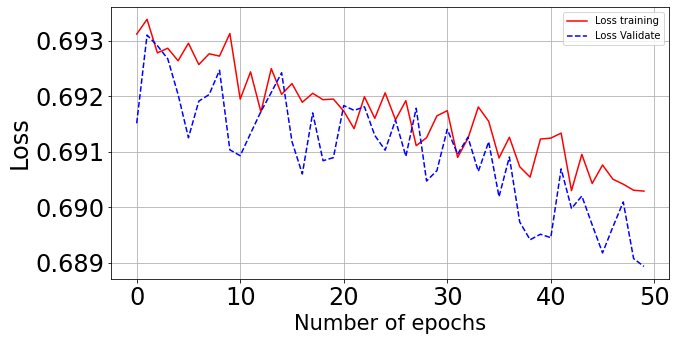

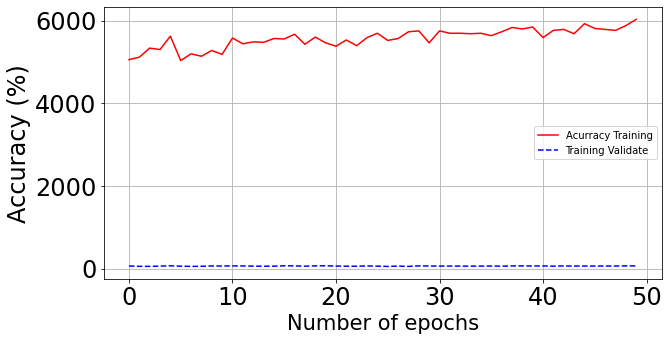

In [ ]:
plotTraining(model_history, epoch, 'loss')
plotTraining(model_history, epoch, 'accuracy')
plotTraining(model_history, epoch, 'val_loss')
plotTraining(model_history, epoch, 'val_accuracy')